### Try custom implementation of ESN layer on base ESN

**Outline**

* Since we are now able to use **additive decomposition** of timeseries into linear trend, seasonality and residual noise, as in [Kim and King, 2020](https://link.springer.com/article/10.1007/s00521-020-04948-x) paper "Time series prediction using Deep Echo State Networks", we are soon ready to switch from base ESN to Deep ESN models.
* But first we import some stock index values (S&P 500) and play with **gridsearch-optimization** on smoothing parameters $alpha$ and $gamma$ and cycle length $s$.
* Then we use our **customized implementation of ESN layers**, based on [tensorflow implementation](https://www.tensorflow.org/addons/api_docs/python/tfa/layers/ESN), for setting up **base ESN**.
* In this experiment we use own useful functions from **ESN_functions_v02.py**.

**Sources**

* Additionally could have a look at [customized implementation](https://github.com/francesco-mannella/Echo-State-Networks) by Francesco Mannella.

#### Technical setup and data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import tensorflow.keras.initializers as tfi
from tensorflow.keras.utils import plot_model

# Work with my own library of useful ESN functions
from ESN_functions_v02 import *

In [2]:
# Read dataset SP500_1999_2019.txt, absolute values:
SP500_abs = open("../data/SP500_1999_2019.csv").read().split()
SP500_abs = np.array(SP500_abs).astype('float64')

# Create relative change values
SP500_rel_chg = (SP500_abs[1:] - SP500_abs[:-1]) / SP500_abs[:-1]

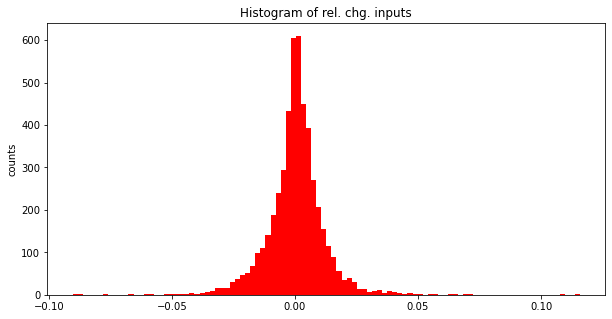

In [3]:
# check distribution of rel. change values
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(SP500_rel_chg, nBins, color="red")
axes.set_ylabel("counts")
axes.set_title("Histogram of rel. chg. inputs")
plt.show()

original input series shape:  (5000, 1)
train_input shape:  (3992, 10, 4)
val_input shape:  (998, 10, 4)
train_target shape:  (3992, 1)
val_target shape:  (998, 1)
train_min:  676.53
train_max:  2130.82


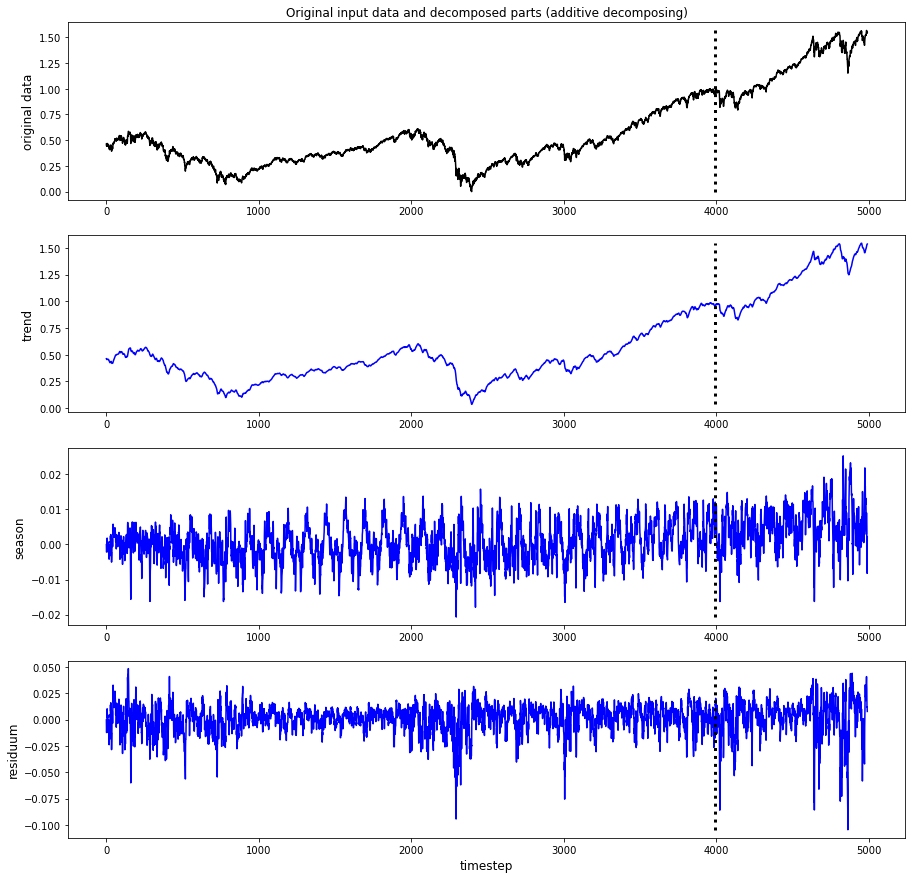


original:
ADF Statistic: 0.937927
p-value: 0.993566

Trend L:
ADF Statistic: 1.063965
p-value: 0.994897

Season S:
ADF Statistic: -9.959887
p-value: 0.000000

Residuum R:
ADF Statistic: -13.925091
p-value: 0.000000


Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [4]:
train_input, val_input, train_target, val_target, input_min, input_max = decompose_split(SP500_abs,
                                                                                         input_length=10,
                                                                                         target_length=1,
                                                                                         train_val_split=0.8,
                                                                                         alpha=0.15,
                                                                                         gamma=0.15,
                                                                                         s=126,
                                                                                         scaled_YN=True,
                                                                                         verbose=True)

In [ ]:
# Gridsearch optimization of smoothing parameters (alpha and gamma) and cycle length (s).
p_values, alpha_series, gamma_series, s_series, input_series_min, input_series_max = decompose_gridsearch(input_series=SP500_abs,
                                                    alpha_min=0.01, alpha_max=0.15, alpha_steps=15,
                                                    gamma_min=0.01, gamma_max=0.15, gamma_steps=15,
                                                    s_min=120, s_max=130, s_steps=11,
                                                    scaled_YN=True, verbose=True)

In [ ]:
# Show series used in gridsearch: alpha, gamma and s
print("\nalpha_series: ", alpha_series)
print("gamma_series: ", gamma_series)
print("s_series: ", s_series)

In [ ]:
## Save p-values array from gridsearch for later re-use.
#np.save("../results/SP500_pValues_01.npy", p_values)

## Re-load p-values array from file:
#p_values_reloaded = np.load("../results/SP500_pValues_01.npy")

In [ ]:
### Plot p-value heatmaps (alpha-gamma-grid):
# Three columns (L, S, R) and s_steps rows.

# Loop over s:
for s in range(p_values.shape[-1]):
    print("\ncycle length s: ", int(s_series[s]))
    
    # Create subplots:
    fig, axes = plt.subplots(1, 3, figsize=(15,5))

    im = axes[0].imshow(p_values[:,:,0,s], cmap='coolwarm', interpolation='nearest')
    axes[0].set_xticks(ticks=range(p_values.shape[0]), labels=np.round((alpha_series), 2), rotation=90)
    axes[0].set_yticks(ticks=range(p_values.shape[1]), labels=np.round((gamma_series), 2))
    axes[0].set_xlabel("gamma", fontsize=12)
    axes[0].set_ylabel("alpha", fontsize=12)
    axes[0].set_title("p-values for linear trend L") 

    im = axes[1].imshow(p_values[:,:,1,s], cmap='coolwarm', interpolation='nearest')
    axes[1].set_xticks(ticks=range(p_values.shape[0]), labels=np.round((alpha_series), 2), rotation=90)
    axes[1].set_yticks(ticks=range(p_values.shape[1]), labels=np.round((gamma_series), 2))
    axes[1].set_xlabel("gamma", fontsize=12)
    axes[1].set_ylabel("alpha", fontsize=12)
    axes[1].set_title("p-values for season S") 

    im = axes[2].imshow(p_values[:,:,2,s], cmap='coolwarm', interpolation='nearest')
    axes[2].set_xticks(ticks=range(p_values.shape[0]), labels=np.round((alpha_series), 2), rotation=90)
    axes[2].set_yticks(ticks=range(p_values.shape[1]), labels=np.round((gamma_series), 2))
    axes[2].set_xlabel("gamma", fontsize=12)
    axes[2].set_ylabel("alpha", fontsize=12)
    axes[2].set_title("p-values for residuum R") 

    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    #fig.colorbar(im, cax=cbar_ax)

    plt.show()



### Discussion on interim results

Performed gridsearch on smoothing parameters $\alpha$ and $\gamma$ for various cycle lengths $s$. Find $\alpha = \gamma = 0.15$ with $s = 126$ to yield $p-values = 0.0$ for decomposed seasonality $S$ and residuum $R$. A more smooth linear trend $L$ is achieved for $\alpha = \gamma = 0.15$ with $s = 126$, but as a result we find a slightly higher $p-value = 0.036$ for seasonality $S$ then.

So far focussed on ranges $[0.01, 0.15]$ for $\alpha$ and $\gamma$, and $[120, 130]$ for $s$.

Leave it like this for the moment. Could later perform a more extensive gridsearch on *nesh*.

And could also investigate observed "jumps" in p-value grids from e.g. $\alpha = 0.01$ line to $\alpha = 0.02$ for $s = 120$.

### ESN with customized ESN_layer

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp97kyjlsr.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp97kyjlsr.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 4)]           0         
_________________________________________________________________
esn (ESN)                    ((None, 10, 100), (None,  10600     
___________________________________________________

2022-02-23 13:18:32.531925: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


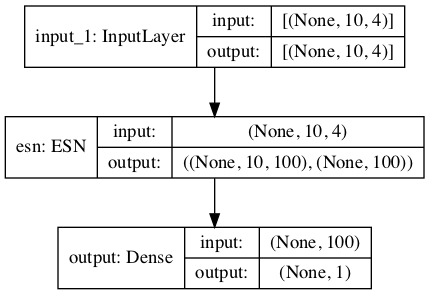

In [5]:
### Set up base ESN model custom layer

# Set (hyper-)parameters:
n_res = 100 # Number of reservoir units
W_in_lim = 1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 1 # Leak rate for transition of reservoir states
spec_radius = 1.0 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix
sparsity = 0.2 # Sparsity of reservoir weight matrix
input_length = 10 # Input length
target_length = 1 # Target length
n_features = 4 # Number of input features: Original series plus decomposed parts L, S and R

# Input layer
model_inputs = Input(shape=(input_length,n_features)) # (timesteps, features)

# Use custom layer for setting up reservoir, returns ALL reservoir states X and FINAL reservoir states X_T.
X, X_T = ESN(n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate)(model_inputs)

# Output unit
output = Dense(units=1, activation=None, use_bias=True, 
               kernel_initializer=tfi.RandomUniform(minval=-W_in_lim, maxval=W_in_lim, seed=None),
               bias_initializer=tfi.RandomUniform(minval=-W_in_lim, maxval=W_in_lim, seed=None),
               name='output')(X_T)

# Define model
model = Model(model_inputs, output, name='model')
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
## Modify reservoir weights W_res using spectral radius:

# Get model weights for ALL layers
model_weights = np.array(model.get_weights())
print("\nmodel_weights shape: ", model_weights.shape)

# Extract reservoir weights and biases
W_res = model_weights[2]
b_res = model_weights[3]
print("W_res shape: ", W_res.shape)
print("b_res shape: ", b_res.shape)

# Check sparsity and max. Eigenvalue BEFORE modification
print("\n Before modification:")
print("\nW_res sparsity: ", sum(sum(W_res != 0)) / (W_res.shape[0]**2))
print("W_res max EV: ", np.max(np.real((np.linalg.eigvals(W_res)))))

# Need temporary matrix W_temp to implement sparsity manually
W_temp = np.random.uniform(low=0, high=1, size=(n_res,n_res))
W_sparse = W_temp <= sparsity

# Now apply sparsity to initial W_res
W = W_sparse * W_res

# Get largest Eigenvalue of W
ev_max = np.max(np.real(np.linalg.eigvals(W)))

# Finally set up W_res
W_res = spec_radius * W / ev_max

## Optionally set reservoir biases to zeros
#b_res = np.zeros(b_res.shape)

# Integrate modified reservoir weights and optionally modified biases into model weights
model_weights[2] = W_res
#model_weights[3] = b_res
model.set_weights(model_weights)

# Check sparsity and max. Eigenvalue AFTER modification
W_res = model_weights[2]
print("\n After modification:")
print("\nW_res sparsity: ", sum(sum(W_res != 0)) / (W_res.shape[0]**2))
print("W_res max EV: ", np.max(np.real((np.linalg.eigvals(W_res)))))

In [ ]:
## For training output weights W_out with closed form solution

# Declare "short" model to get final reservoir states X_T for train inputs:
model_short = Model(model_inputs, X_T, name='model_short')
model_short.summary()
plot_model(model_short, show_shapes=True, show_layer_names=True)

### Solving for output weights with linear regression, use "augmented" notation

Short model yields final reservoir states $X(T)$ with dimension (#samples, #reservoir units). We then have outputs weights $W_{out}$ with shape (#reservoir units, 1) and output bias $b_{out}$ as single value. Train targets $Y$ have dimension (#samples, 1).

The relation between final reservoir states, output weights and bias and train targets $Y$ reads:

$$X(T) \cdot W_{out} + \overline{b}_{out} = Y$$

Note: Here $\overline{b}_{out}$ denotes a vector of shape (#samples, 1), containing only the single output bias value $b_{out}$.

We switch to "augmented" notation and include $\overline{b}_{out}$ as additional column in $X(T)$. This requires to add $1$ at the end of $W_{out}$, for keeping dimensions right. This leads to:

$$X'(T) \cdot W'_{out} = Y$$

where $X'(T)$ and $W'_{out}$ denote final reservoir states and output weights in augmented notation, respectively. Note: Later we might ommit the primes - for convenience.

Solving for $W'_{out}$ we need to invert $X'(T)$, or get the pseudo-inverse $X'_{inv}$, since $X'(T)$ is usually not a square matrix:

$$W'_{out} = X'_{inv} \cdot Y$$

In [ ]:
# Get final reservoir states for all train samples from short model
print("\nshape of train input (samples, timesteps, features): ", train_input.shape)
X_T_train = model_short.predict(train_input)
print("shape of model output X_T (samples, n_res): ", X_T_train.shape)

In [ ]:
# Extract output weights and bias
model_weights = np.array(model.get_weights())
W_out = model_weights[4]
b_out = model_weights[5]
print("\nW_out shape: ", W_out.shape)
print("b_out shape: ", b_out.shape)
#print("\nW_out: \n", W_out)
#print("\nb_out: \n", b_out)

In [ ]:
# Create vector of shape (samples, 1) containing only the single constant output bias as values.
b_out_vec = np.ones((X_T_train.shape[0], 1)) * b_out
print("\nb_out_vec shape: ",  b_out_vec.shape)

In [ ]:
# Add b_out vector as additional column to final reservoir states X_T_train.
X_T_train_prime = np.concatenate((X_T_train, b_out_vec), axis=-1)
print("\nFinal reservoir states in augmented notation, shape: ", X_T_train_prime.shape)

In [ ]:
# Then need pseudo-inverse of final reservoir states in augmented notation
X_inv_prime = np.linalg.pinv(X_T_train_prime)

# Then get output weights, in augmented notation
W_out_prime = np.matmul(X_inv_prime, train_target)

print("train_input shape: ", train_input.shape)
print("train_target shape: ", train_target.shape)        
print("W_out_prime shape: ", W_out_prime.shape)

In [ ]:
# Now split output weights in augmented notation into trained output weights W_out and output bias b_out.
W_out = W_out_prime[:-1,:]
b_out = W_out_prime[-1:,0]
#print("\nW_out: \n", W_out)
#print("\nb_out: \n", b_out)

In [ ]:
# Integrate trained output weights and bias into model weights
model_weights[4] = W_out
model_weights[5] = b_out
model.set_weights(model_weights)

In [ ]:
# Check result: Are trained output weights and bias really integrated into the model?
model_weights = np.array(model.get_weights())
#print("\nW_out: \n", model_weights[4])
#print("\nb_out: \n", model_weights[5])

In [ ]:
## Get predictions from "long" model on train and validation input
print("\nshape of val input (samples, timesteps, features): ", val_input.shape)
print("shape of train input (samples, timesteps, features): ", train_input.shape)
val_pred = model.predict(val_input)
train_pred = model.predict(train_input)

print("\nshape of model predictions on validation input (samples, 1): ", val_pred.shape)
print("shape of val targets (samples, 1): ", val_target.shape)

# Calculate mean-absolute and mean-squared error of model predictions compared to validation targets:
val_mae = np.round(sum(np.abs(val_target[:,0] - val_pred[:,0])) / len(val_target), 4)
train_mae = np.round(sum(np.abs(train_target[:,0] - train_pred[:,0])) / len(train_target), 4)
print("\nval_mae: ", val_mae)
print("train_mae: ", train_mae)


# Fidelity check: Plot val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred,'k',  alpha=0.8, label='pred ESN')
plt.legend()
plt.show()

### Alternative attempt to solve for output weights with linear regression, without "augmented" notation

Our attempt to use "augmented" notation and include output bias $b_{out}$ as additional column in final reservoir states $X(T)$ failed. Inverting $X(T)$ drives bias to huge values and leads to poor prediction performance. So let's try another approach now. Remember:

Short model yields final reservoir states $X(T)$ with dimension (#samples, #reservoir units). We then have outputs weights $W_{out}$ with shape (#reservoir units, 1) and output bias $b_{out}$ as single value. Train targets $Y$ have dimension (#samples, 1).

The relation between final reservoir states, output weights and bias and train targets $Y$ reads:

$$X(T) \cdot W_{out} + \overline{b}_{out} = Y$$

Note: Here $\overline{b}_{out}$ denotes a vector of shape (#samples, 1), containing only the single output bias value $b_{out}$.

Instead of switching to "augmented" notation - we re-arrange the equation to obtain:

$$X(T) \cdot W_{out} = Y - \overline{b}_{out}$$

Solving for $W_{out}$ we need to invert $X(T)$, or get the pseudo-inverse $X_{inv}$, since $X(T)$ is usually not a square matrix:

$$W_{out} = X_{inv} \cdot (Y - \overline{b}_{out})$$

In [ ]:
# Get final reservoir states for all train samples from short model
print("\nshape of train input (samples, timesteps, features): ", train_input.shape)
X_T_train = model_short.predict(train_input)
print("shape of model output X_T (samples, n_res): ", X_T_train.shape)

In [ ]:
# Extract output weights and bias
model_weights = np.array(model.get_weights())
W_out = model_weights[4]
b_out = model_weights[5]
print("\nW_out shape: ", W_out.shape)
print("b_out shape: ", b_out.shape)
#print("\nW_out: \n", W_out)
#print("\nb_out: \n", b_out)

In [ ]:
# Create vector of shape (samples, 1) containing only the single constant output bias as values.
b_out_vec = np.ones((X_T_train.shape[0], 1)) * b_out
print("\nb_out_vec shape: ",  b_out_vec.shape)

In [ ]:
# Then need pseudo-inverse of final reservoir states
X_inv = np.linalg.pinv(X_T_train)

# Then get output weights
W_out = np.matmul(X_inv, train_target - b_out_vec)

print("train_input shape: ", train_input.shape)
print("train_target shape: ", train_target.shape)        
print("W_out shape: ", W_out.shape)

In [ ]:
# Integrate trained output weights into model weights
model_weights[4] = W_out
model.set_weights(model_weights)

In [ ]:
## Get predictions from "long" model on train and validation input
print("\nshape of val input (samples, timesteps, features): ", val_input.shape)
print("shape of train input (samples, timesteps, features): ", train_input.shape)
val_pred = model.predict(val_input)
train_pred = model.predict(train_input)

print("\nshape of model predictions on validation input (samples, 1): ", val_pred.shape)
print("shape of val targets (samples, 1): ", val_target.shape)

# Calculate mean-absolute and mean-squared error of model predictions compared to validation targets:
val_mae = np.round(sum(np.abs(val_target[:,0] - val_pred[:,0])) / len(val_target), 4)
train_mae = np.round(sum(np.abs(train_target[:,0] - train_pred[:,0])) / len(train_target), 4)
print("\nval_mae: ", val_mae)
print("train_mae: ", train_mae)


# Fidelity check: Plot val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred,'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data')
plt.legend()
plt.show()


# Fidelity check: Plot train_pred vs. train_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(train_target)),train_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(train_pred)),train_pred,'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on TRAIN data')
plt.legend()
plt.show()

### Discussion on alternative ways to solve for output weights

As we have seen above, switching to "augmented" notation fails. Secondly we tried another approach with keeping output bias $b_{out}$ in the equation:

$$W_{out} = X_{inv} \cdot (Y - \overline{b}_{out})$$

This works fine. However, fidelity check on validation data shows some mysterious behavior: For the first 400 timesteps model prediction match true validation targets, before they drift heavily apart.

My first intuition was that there might be a problem with reservoir biases, so I set them to *zero*. This leads to even more mystery: Now model prediction and targets not only drift apart after some 400 timesteps, but predictions are also *inverted*. This effect needs to be further investigated later. So far stick to using reservoir biases with random initialization.

Later tried to double input length (from 10 to 20 timesteps) and found that weird *inversion* of model predictions compared to true validation targets. So it's more likely to be an artefact from initialization of weights and needs to be further investigated.

Working with un-scaled input values fails completely, model predicts some absurd constant value.

Running model multiple times *can* lead to quite nice fidelity, have seen result where model predictions and validation targets matched up to 600 timesteps, before only slightly drifting apart.

**Note:** We introduces *leak_rate* here from [Kim and King, 2020](https://link.springer.com/article/10.1007/s00521-020-04948-x) paper, used in reservoir transition function. Just rather randomly chose $leak_rate=0.5$ in first attempts. This could cause stability problems and needs to be fine-tuned!

Or one could try 'sigmoid' function instead of 'tanh' in reservoir transition...